# Characters Classification with Neural Networks

In this notebook we are going to use the Neural Networks for image classification. We are going to use the same dataset of the lab on SVM: Kuzushiji-MNIST or K-MNIST for short (https://github.com/rois-codh/kmnist) a dataset of traditional japanese handwritten kana.

The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

In [1]:
#load the required packages and check Scikit-learn version

%matplotlib inline  

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import sklearn
print ('scikit-learn version: ', sklearn.__version__)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

scikit-learn version:  0.24.2


In [2]:
# helper function to load KMNIST dataset from disk
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    return images, labels

# TODO 
Set as seed for the random generator your Student ID (you can use your "numero di matricola"). Try to change the seed to see the impact of the randomization.

In [3]:
ID = 2053348
np.random.seed(ID)

In [4]:
#load the MNIST dataset and let's normalize the features so that each value is in [0,1]
X, y = load_mnist("data")
print("Number of samples in the K-MNIST dataset:", X.shape[0])
# rescale the data
X = X / 255.0

Number of samples in the K-MNIST dataset: 60000


Now split into training and test. We start with a small training set of 600 samples to reduce computation time while 4000 samples will be used for testing. Make sure that each label is present at least 10 times in train and test set frequencies.

In [80]:
#random permute the data and split into training and test taking the first 600
#data samples as training and 4000 as test set
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

m_training = 600
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

labelsT, freqsT = np.unique(y_test, return_counts=True)
print("Labels in test set: ", labelsT)
print("Frequencies in test set: ", freqsT)


Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [45 65 60 58 65 71 56 58 57 65]
Labels in test set:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in test set:  [398 396 394 419 390 385 397 417 393 411]


In [7]:
#function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("INPUT:")
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    print("LABEL: %i"%labels[index])
    return

INPUT:


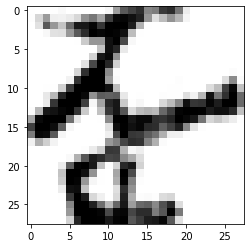

LABEL: 9
INPUT:


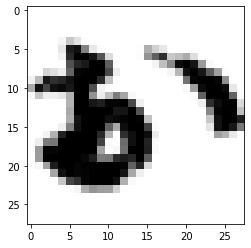

LABEL: 0
INPUT:


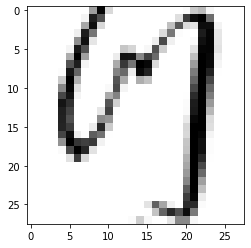

LABEL: 3


In [8]:
#let's try the plotting function
plot_input(X_train,y_train,10)
plot_input(X_test,y_test,100)
plot_input(X_test,y_test,1000)

### TO DO 1

Now use a feed-forward Neural Network for prediction. Use the multi-layer perceptron classifier, with the following parameters: max_iter=100, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1, random_state=ID (this last parameter ensures the run is the same even if you run it more than once). The alpha parameter is the regularization term.

Then, using the default activation function, pick four or five architectures to consider, with different numbers of hidden layers and different sizes. It is not necessary to create huge neural networks, you can limit to 3 layers and, for each layer, its maximum size can be of 50. Evaluate the architectures you chose using GridSearchCV with cv=5.

You can reduce the number of iterations if the running time is too long on your computer.


In [42]:
# these are sample values but feel free to change them as you like, try to experiment with different sizes!!
parameters = {'hidden_layer_sizes': [(10,), (48,), (49,), (35,), (24,24,), (40,20,30) ]}

mlp = MLPClassifier(max_iter=100, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID,
                    learning_rate_init=.1)

grid_search_mlp = GridSearchCV(mlp, parameters, cv=5)
grid_search_mlp.fit(X_train, y_train)

print ('RESULTS FOR NN\n')

print("Best parameters set found:")
print(grid_search_mlp.best_params_)

print("Score with best parameters:")
print(grid_search_mlp.best_score_)

print("All scores on the grid:")
print(grid_search_mlp.cv_results_['mean_test_score'])

RESULTS FOR NN

Best parameters set found:
{'hidden_layer_sizes': (48,)}
Score with best parameters:
0.75
All scores on the grid:
[0.67       0.75       0.72666667 0.73833333 0.71166667 0.69166667]


### TO DO 2

Now try also different batch sizes, while keeping the best NN architecture you have found above. Remember that the batch size was previously set to the default value, i.e., min(200, n_samples). 
Recall that a batch size of 1 corresponds to baseline SGD, while using all the 480 training samples (there are 600 samples but in cross validation with 5 folders we use 1/5 of them for validation at each round) corresponds to standard GD and using a different mini-batch size lies in the middle between the two extreme cases.

In [45]:
# these are sample values corresponding to baseline SGD, a reasonable mini-batch size and standard GD
# again feel free to change them as you like, try to experiment with different batch sizes!!
parameters = {'batch_size': [1,50, 100, 150, 200, 250, 300, 350, 400, 450, 480]}

# need to specify that you would like to use the standard k-fold split otherwise sklearn create splits of different sizes
kf = sklearn.model_selection.KFold(n_splits=5)

mlp = MLPClassifier(hidden_layer_sizes=grid_search_mlp.best_params_['hidden_layer_sizes'], max_iter=100, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID,
                    learning_rate_init=.1)

# recall to use cv=kf to use the k-fold subdivision seen in the lectures

grid_search_mlp_ = GridSearchCV(mlp, parameters, cv=kf)
grid_search_mlp_.fit(X_train, y_train)


print("Best parameters set found:")
print(grid_search_mlp_.best_params_)

print("Score with best parameters:")
print(grid_search_mlp_.best_score_)

print("All scores on the grid:")
print(grid_search_mlp_.cv_results_['mean_test_score'])

/home/gfrances/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gfrances/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gfrances/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gfrances/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gfrances/miniconda3/li

Best parameters set found:
{'batch_size': 480}
Score with best parameters:
0.7416666666666667
All scores on the grid:
[0.09666667 0.73166667 0.74       0.73666667 0.73166667 0.73666667
 0.74       0.73833333 0.735      0.72833333 0.74166667]


### QUESTION 1

What do you observe for different architectures and batch sizes? How do the number of layers and their sizes affect the performances? What do you observe for different batch sizes, in particular what happens to the training convergence for different batch sizes (notice that the algorithm could not converge for some batch sizes)?

## [ANSWER TO QUESTION 1]

### TODO 3:

Plot the train and test accuracies as a function of the number of learnable parameters in your neural network. Print also the computation time for the various configurations you try (the code for getting the computation time is already provided). You can use 100 iterations (if you get a warning on convergence not reached it is not an issue for this lab)

Training MLP of size (10,) ...


/home/gfrances/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Done, training time: 0.20 sec

Training MLP of size (48,) ...
Done, training time: 0.26 sec

Training MLP of size (49,) ...
Done, training time: 0.25 sec

Training MLP of size (35,) ...
Done, training time: 0.22 sec

Training MLP of size (24, 24) ...
Done, training time: 0.16 sec

Training MLP of size (40, 20, 30) ...
Done, training time: 0.20 sec



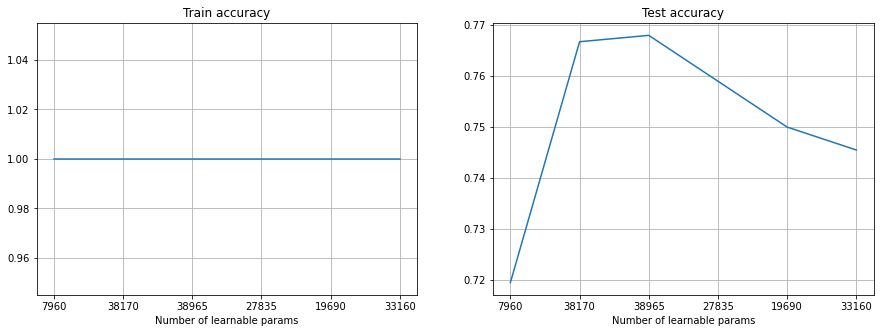

In [47]:
import time
from functools import reduce

# Function to compute the number of learnable parameters of a mlp given the size of its hidden layers
def param_count(hl_size):
    tot = 0
    input_size, output_size = X_train.shape[1], len(labels)
    tot += (input_size+1)*hl_size[0]
    for i in range(1,len(hl_size)):
        tot += (hl_size[i-1]+1)*hl_size[i]
    tot += (hl_size[-1]+1)*output_size
    return tot

hl_sizes = [(10,), (48,), (49,), (35,), (24,24,), (40,20,30) ]
hl_labels = [param_count(t) for t in hl_sizes]

ti = time.time()
train_acc_list, test_acc_list = [], []
for hl_size in hl_sizes:
    print('Training MLP of size {} ...'.format(hl_size))
    mlp = MLPClassifier(hidden_layer_sizes=hl_size, max_iter=100, alpha=1e-4, solver='sgd',
                    tol=1e-4, random_state=ID,
                    learning_rate_init=.1)
    
    mlp.fit(X_train, y_train)
    
    train_acc_list.append(mlp.score(X_train, y_train))
    test_acc_list.append(mlp.score(X_test, y_test))
    print('Done, training time: {:.2f} sec\n'.format(time.time()-ti))
    ti = time.time()

fig, ax = plt.subplots(1,2, figsize=(15,5))


ax[0].plot(train_acc_list)
ax[0].set_xlabel('Number of learnable params')
ax[0].set_title('Train accuracy')
ax[0].set_xticks(np.arange(0,len(hl_labels)))
ax[0].set_xticklabels(hl_labels)
ax[0].grid(True)

ax[1].plot(test_acc_list)
ax[1].set_xlabel('Number of learnable params')
ax[1].set_title('Test accuracy')
ax[1].set_xticks(np.arange(0,len(hl_labels)))
ax[1].set_xticklabels(hl_labels)
ax[1].grid(True)


## Question 2:

Comment about the training and test accuracies referring to the discussion on underfitting and overfitting we did in the course

## [ANSWER TO QUESTION 2]

### TO DO 4

Now try also to use different learning rates, while keeping the best NN architecture and batch size you have found above. Plot the learning curves (i.e., the variation of the loss over the steps, you can get it from the loss_curve_ object of sklearn) for the different values of the learning rate. Try to run each training for 100 iterations. 

/home/gfrances/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gfrances/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/gfrances/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


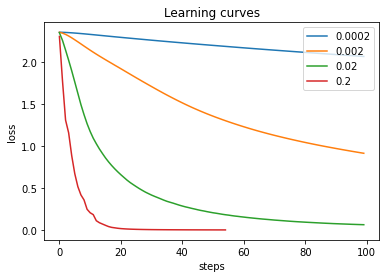

RESULTS FOR NN

Best parameters set found:
0.2
Score with best parameters:
1.0


In [59]:
import matplotlib.pyplot as plt
import operator

lr_list = [0.0002, 0.002, 0.02, 0.2]
scores = {}
# grid search or not? score with test or train? it's right to stop before larger steps?
for lr in lr_list:
    #print('Training MLP w lr {} ...'.format(lr))
    mlp = MLPClassifier(hidden_layer_sizes=grid_search_mlp.best_params_['hidden_layer_sizes'], 
                    batch_size=grid_search_mlp_.best_params_['batch_size'], 
                    learning_rate_init=lr, 
                    max_iter=100, alpha=1e-4, solver='sgd', tol=1e-4, random_state=ID)
    
    mlp.fit(X_train, y_train)
    scores[str(lr)]=mlp.score(X_train, y_train)
    plt.plot(mlp.loss_curve_, label=str(lr))

plt.legend(loc='upper right')
plt.title("Learning curves")
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()

best_score = 0
best_lr = ""
for lr, score in scores.items():
    if score >= best_score :
        best_score = score
        best_lr = lr

print ('RESULTS FOR NN\n')

print("Best parameters set found:")
print(best_lr)

print("Score with best parameters:")
print(best_score)




### QUESTION 3

Comment about the learning curves (i.e. the variation of the loss over the steps). How does the curve changes for different learning rates in terms of stability and speed of convergence ?

## [ANSWER TO QUESTION 3]

### TO DO 5

Now get training and test error for a NN with best parameters (architecture, batch size and learning rate) from above. Plot the learning curve also for this case (you can run the training for 500 iterations).


RESULTS FOR BEST NN

Best NN training error: 0.000000
Best NN test error: 0.256500


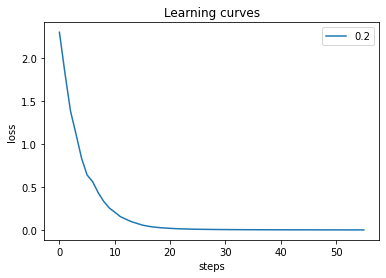

In [81]:
#get training and test error for the best NN model from CV

mlp = MLPClassifier(hidden_layer_sizes=grid_search_mlp.best_params_['hidden_layer_sizes'], 
                    batch_size=grid_search_mlp_.best_params_['batch_size'], 
                    learning_rate_init=float(best_lr), 
                    max_iter=500, alpha=1e-4, solver='sgd', tol=1e-4, random_state=ID)
mlp.fit(X_train, y_train)
training_error = 1 - mlp.score(X_train, y_train)
test_error      = 1 - mlp.score(X_test, y_test)

print ('\nRESULTS FOR BEST NN\n')

print ("Best NN training error: %f" % training_error)
print ("Best NN test error: %f" % test_error)

plt.plot(mlp.loss_curve_, label=str(best_lr))

plt.legend(loc='upper right')
plt.title("Learning curves")
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()

## More data 
Now let's do the same but using 4000 (or less if it takes too long on your machine) data points for training. Use the same NN architecture as before, but you can try more if you like and have a powerful computer!!

In [82]:
X = X[permutation]
y = y[permutation]

m_training = 40000

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [3994 4002 4006 3975 4057 3966 3997 3964 3975 4064]


### TO DO 6

Now train the NNs with the added data points using the optimum parameters found above. Eventually, feel free to try different architectures if you like. We suggest that you use 'verbose=True' so have an idea of how long it takes to run 1 iteration (eventually reduce also the number of iterations to 50).

In [83]:
# use best architecture and params from before

best_mlp = MLPClassifier(hidden_layer_sizes=grid_search_mlp.best_params_['hidden_layer_sizes'], 
                    batch_size=grid_search_mlp_.best_params_['batch_size'], 
                    learning_rate_init=float(best_lr), 
                    max_iter=500, alpha=1e-4, solver='sgd', tol=1e-4, random_state=ID, verbose=True)
best_mlp.fit(X_train, y_train)

print ('\nRESULTS FOR NN\n')

#get training and test error for the NN

training_error = 1 - best_mlp.score(X_train, y_train)
test_error      = 1 - best_mlp.score(X_test, y_test)

print ("NN training error: %f" % training_error)
print ("NN test error: %f" % test_error)


Iteration 1, loss = 0.63931276
Iteration 2, loss = 0.29693513
Iteration 3, loss = 0.23291424
Iteration 4, loss = 0.19601657
Iteration 5, loss = 0.16918533
Iteration 6, loss = 0.15023391
Iteration 7, loss = 0.13370394
Iteration 8, loss = 0.12098393
Iteration 9, loss = 0.10808809
Iteration 10, loss = 0.09689800
Iteration 11, loss = 0.08797998
Iteration 12, loss = 0.07911153
Iteration 13, loss = 0.07049138
Iteration 14, loss = 0.06422632
Iteration 15, loss = 0.05833708
Iteration 16, loss = 0.05087389
Iteration 17, loss = 0.04557577
Iteration 18, loss = 0.04023256
Iteration 19, loss = 0.03528283
Iteration 20, loss = 0.03191269
Iteration 21, loss = 0.02976098
Iteration 22, loss = 0.02622882
Iteration 23, loss = 0.02073167
Iteration 24, loss = 0.01969001
Iteration 25, loss = 0.01669231
Iteration 26, loss = 0.01480970
Iteration 27, loss = 0.01202072
Iteration 28, loss = 0.01011238
Iteration 29, loss = 0.00877109
Iteration 30, loss = 0.00810454
Iteration 31, loss = 0.00712113
Iteration 32, los

## QUESTION 4
Compare the train and test error you got with a large number of samples with the best one you obtained with only 600 data points. Comment about the results you obtained.

#### [ANSWER TO QUESTION 4]

### TO DO 7

Plot an example that was missclassified by NN with m=600 training data points and it is now instead correctly classified by NN with m=4000 training data points.

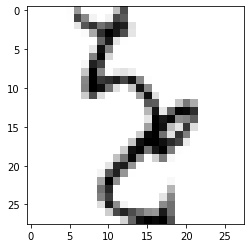

In [84]:
NN_prediction = mlp.predict(X_test)
large_NN_prediction = best_mlp.predict(X_test)

for y_pred, y_large_pred, y_true, x_true in zip(NN_prediction, large_NN_prediction, y_test, X_test):
    if (y_pred != y_true) and (y_large_pred == y_true) :
        plt.imshow(x_true.reshape(28,28), cmap = plt.cm.gray_r, interpolation = "nearest")
        plt.show()
        break;

### TO DO 8

Let's plot the weigths of the multi-layer perceptron classifier, for the best NN we get with 600 data points and with 4000 data points. The code is already provided, just fix variable names (e.g., replace mlp , mlp_large with your estimators) in order to have it working with your implementation



Weights with 600 data points:


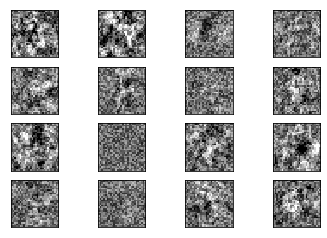

Weights with 4000 data points:


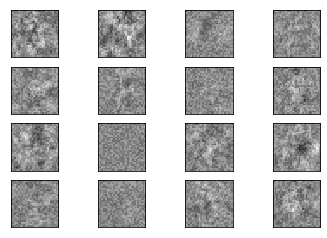

In [85]:
print("Weights with 600 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

print("Weights with 4000 data points:")

fig, axes = plt.subplots(4, 4)
vmin, vmax = best_mlp.coefs_[0].min(), best_mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

## QUESTION 5

Describe what do you observe by looking at the weights.

##### [ANSWER TO QUESTION 5]

### TO DO 9

Take the best SVM model and its parameters, you found in the last notebook. Fit it on a few data points and compute its training and test scores. Then fit also a logistic regression model with C=1. 

In [88]:
m_training = 5000# why this size and strange 2*??

X_train, X_test = X[:m_training], X[m_training:2*m_training]
y_train, y_test = y[:m_training], y[m_training:2*m_training]

# use best parameters found in the SVM notebook, create SVM and perform fitting
best_params = {'C': 10, 'gamma': 0.01}

SVM = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
SVM.fit(X_train, y_train)

training_error = 1-SVM.score(X_train, y_train)
test_error     = 1-SVM.score(X_test, y_test)
print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

print ('RESULTS FOR SVM')

SVM_training_score =  1-training_error
print("Training score SVM:")
print(SVM_training_score)

SVM_test_score = 1-test_error
print("Test score SVM:")
print(SVM_test_score)

Best SVM training error: 0.000000
Best SVM test error: 0.078000
RESULTS FOR SVM
Training score SVM:
1.0
Test score SVM:
0.922


In [89]:
from sklearn import linear_model

# regL2 = #ADD YOUR CODE

# you can re-use your code from Lab 2

logistic_reg = linear_model.LogisticRegression(max_iter=1000).fit(X_train, y_train)
training_error = 1-logistic_reg.score(X_train, y_train)
test_error     = 1-logistic_reg.score(X_test, y_test)

print ('\nRESULTS FOR LOGISTIC REGRESSION WITH REGULARIZATION')
print ("Training error (reg): %f" % training_error)
print ("Test error (reg): %f" % test_error)


RESULTS FOR LOGISTIC REGRESSION WITH REGULARIZATION
Training error (reg): 0.026400
Test error (reg): 0.256000


## QUESTION 6
Compare the results of Logistic Regression, SVM and NN. Which one achieve the best results? 

###### [ANSWER TO QUESTION 6]